## Crowdsourcing task optimization

We want a plot a summary of the performance of the algorith, then we want to optimize the constraints below

Variables incluided as widgets:
- Number of workers
- Number of tasks
- Number of tasks per worker
- % Hard/Easy tasks
- % Poor/Good workers

In [1]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
%matplotlib inline

---
### Tasks and Workers Dataframe Construction

In [2]:
total_tasks = 100 #input()

In [3]:
total_workers = 65 #40

In [4]:
#Tasks variables
p_hard_tasks = 0.2
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))

p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))

In [5]:
print(n_hard_tasks, n_easy_tasks)

20 80


In [6]:
#Workers variables
p_good_workers = 0.8
n_good_workers = int(round(p_good_workers*total_workers,0))

p_poor_workers = 1-p_good_workers
n_poor_workers = int(round(p_poor_workers*total_workers,0))

In [7]:
print(n_good_workers, n_poor_workers)

52 13


Let's create a simulated workers and tasks depending on the variables we already set up, the samples are without [replacement](https://www.ma.utexas.edu/users/parker/sampling/repl.htm)

- Workers

In [8]:
workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]

In [9]:
poor_workers = [worker for worker in np.random.choice(workers, n_poor_workers, replace=False)]

In [10]:
good_workers = [worker for worker in set(workers)-set(poor_workers)]

Every person have (number of tasks) to accomplish, so we select randomlly from the tasks id with replacement for every person

In [11]:
# Creating the workers dataframe
df_workers = pd.DataFrame()
df_workers['worker_id'] = workers

In [12]:
label_worker = []
for i in range(total_workers):
    if workers[i] in good_workers:
        label_worker.append('good_worker')
    else:
        label_worker.append('poor_worker')

In [13]:
df_workers['label_worker'] = label_worker

In [14]:
df_workers.head()

,worker_id,label_worker
0,CBgQj,good_worker
1,iWuWu,poor_worker
2,nW6vf,good_worker
3,BqDVP,good_worker
4,buKvr,poor_worker


- Tasks 

In [15]:
tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]

In [16]:
easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]

In [17]:
hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

- Answers

In [18]:
answers_key = ["liver", "blood", "lung", "brain", "heart"]

In [19]:
real_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]

We asign every answer to our simulated vectors

In [20]:
# Creating the tasks data frame
df_tasks = pd.DataFrame()
df_tasks['task_id'] = tasks
df_tasks['real_answers'] = real_answers

In [21]:
label_task = []
for i in range(total_tasks):
    if tasks[i] in hard_tasks:
        label_task.append('hard_task')
    else:
        label_task.append('easy_task')

In [22]:
df_tasks['label_task'] = label_task

In [23]:
df_tasks.head()

,task_id,real_answers,label_task
0,task_TDf,lung,hard_task
1,task_qt7,liver,hard_task
2,task_MYe,brain,easy_task
3,task_QrU,liver,hard_task
4,task_4vx,blood,easy_task


---
### Probabilities to Respond
Predict worker answer based on pre-assumed probabilities

We have to start to think what could it be in a case with real data
- Is there only 2 labels for task difficulty and worker performance?
- What does define a good or poor worker, what threshold?
- In the original problems the probabilities are wrong

$p_T =$ task difficulty  
$p_W =$ worker ability

$$p_T \in (0.5,1)$$
$$p_W \in (0.5,1)$$

- If for a worker the frequency of being certain is the times he participate in concesus tasks
- If for a task the frequency of beign easy is the times is concensus
The less effort means CHANCE

In [24]:
# Threshold of responses
cut_tasks = 0.75
cut_workers = 0.75

In [25]:
probs_tasks = []
for i in label_task:
    if i == 'easy_task':
        probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
    elif i == 'hard_task':
        probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
    else: probs_tasks.append(1)

probs_tasks = [item for prob in probs_tasks for item in prob]

In [26]:
probs_workers = []
for i in label_worker:
    if i == 'good_worker':
        probs_workers.append(np.random.choice((np.arange(cut_workers, 1, 0.01)), 1)) #a random number form cut to 1
    elif i == 'poor_worker':
        probs_workers.append(np.random.choice((np.arange(0.5, cut_workers, 0.01)), 1)) #a random number form chance to 1
    else: probs_workers.append(1)

probs_workers = [item for prob in probs_workers for item in prob]

In [27]:
df_workers['prob_worker'] = probs_workers

In [28]:
df_workers.head()

,worker_id,label_worker,prob_worker
0,CBgQj,good_worker,0.75
1,iWuWu,poor_worker,0.58
2,nW6vf,good_worker,0.91
3,BqDVP,good_worker,0.93
4,buKvr,poor_worker,0.50


In [29]:
df_tasks['prob_task'] = probs_tasks

In [30]:
df_tasks.head()

,task_id,real_answers,label_task,prob_task
0,task_TDf,lung,hard_task,0.57
1,task_qt7,liver,hard_task,0.59
2,task_MYe,brain,easy_task,0.91
3,task_QrU,liver,hard_task,0.62
4,task_4vx,blood,easy_task,0.83


Summary of aggregated probabilities

In [31]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.867125    80
hard_task   0.592500    20

In [32]:
df_workers.groupby('label_worker').agg(['mean','count'])

prob_worker      
                    mean count
label_worker                  
good_worker     0.865769    52
poor_worker     0.628462    13

---
### Stage 1 - Training Workers
- Select the p% of the tasks
- Asign 'workers_per_task' (7 this case) to evrery of the p% of the task on training set
- Melt the dataframe

In [33]:
# It's in the begining also
p_train_tasks = .4 #percentage

In [34]:
workers_per_task = 7 #more conditions

In [35]:
tasks_to_train = int(p_train_tasks*total_tasks)
tasks_to_train

40

In [36]:
# Take randomly the number of tasks to train the workers
training_tasks = np.random.choice(tasks, tasks_to_train, replace=False)
training_tasks

array(['task_XGS', 'task_FuK', 'task_WQN', 'task_Ujg', 'task_Ljx',
       'task_cUd', 'task_mTw', 'task_3Le', 'task_P8F', 'task_Ung',
       'task_DRE', 'task_7ff', 'task_M4o', 'task_Kv6', 'task_EBT',
       'task_2du', 'task_4Gm', 'task_rrn', 'task_4UP', 'task_qt7',
       'task_4Hc', 'task_fpn', 'task_ZyZ', 'task_Bvq', 'task_Er2',
       'task_TDf', 'task_T3K', 'task_8GE', 'task_fmu', 'task_tor',
       'task_bWq', 'task_iAb', 'task_mgZ', 'task_mRC', 'task_tto',
       'task_tQP', 'task_ofw', 'task_NdK', 'task_opL', 'task_3Pz'],
      dtype='<U8')

In [37]:
list_tasks1 = [[training_tasks[i]]*workers_per_task for i in range(tasks_to_train)] #replicate the tasks to train 
list_tasks1 = [item for sublist in list_tasks1 for item in sublist] #flat and clean list

In [38]:
# Asign workers on every task (we're assuming the tasks are ordered)
tasks_workers1 = [np.random.choice(workers, workers_per_task, replace=False) for task in training_tasks]
tasks_workers1 = [worker for sublist in tasks_workers1 for worker in sublist] #flat and clean list

In [39]:
df_tw1 = pd.DataFrame()
df_tw1['task_id'] = list_tasks1
df_tw1['worker_id'] = tasks_workers1

In [40]:
workers_agg = df_tw1.groupby('worker_id').agg('count')

- Should we consider the workers evaluate the same number of tasks??
- How is the design?

In [41]:
workers_agg.sort_values('task_id', ascending=False)

,task_id
worker_id,
W9p5U,10
gsPuU,9
kJE94,8
nW6vf,8
Cy2wy,7
LroGp,6
aVUVQ,6
eKZgL,6
Txsv4,6


In [42]:
len(workers_agg.reset_index())

65

Here we have to train the workers more equal:
    - They should have the same amount of hard and easy tasks
    - They should have the same amount of tasks assigned

---
### Percentage of Training Analysis

What is the minimum percentage of training tasks that asures we gonna have all the workers?

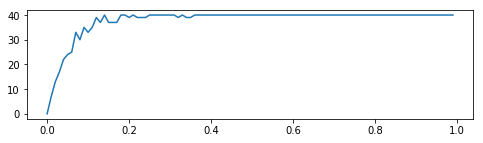

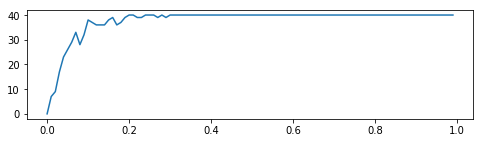

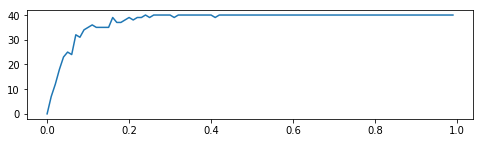

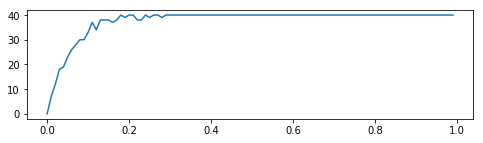

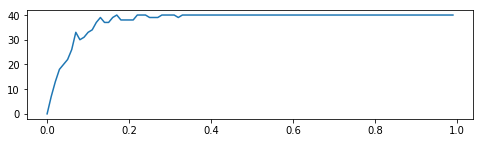

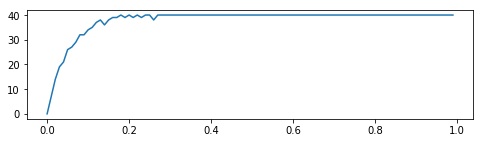

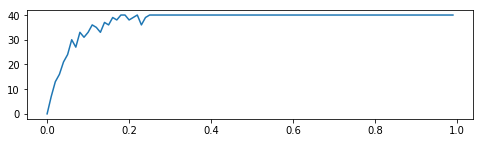

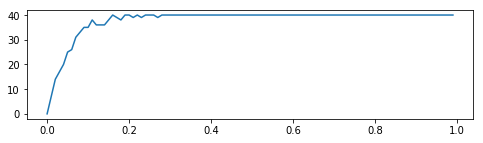

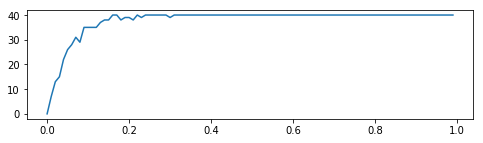

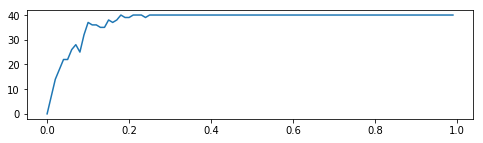

In [43]:
# Run only once after every simulation
for i in range(10):
    plt.figure(figsize=[8, 2])
    perc = []
    uniq = []
    for i in np.arange(0.0, 1, 0.01):
        p_train_tasks = i #percentage
        tasks_to_train = int(p_train_tasks*total_tasks)
        training_tasks = np.random.choice(tasks, tasks_to_train, replace=False)
        list_tasks = [[training_tasks[i]]*workers_per_task for i in range(tasks_to_train)] #replicate the tasks to train 
        list_tasks = [item for sublist in list_tasks for item in sublist] #flat and clean list
        tasks_workers1 = [np.random.choice(workers, workers_per_task, replace=False) for task in training_tasks]
        tasks_workers1 = [worker for sublist in tasks_workers1 for worker in sublist] #flat and clean list
        data = pd.DataFrame()
        data['task_id'] = list_tasks
        data['worker_id'] = tasks_workers1
        agg = data.groupby('worker_id').agg('count') #it's a good idea also include the max tasks per user
        perc.append(i)
        uniq.append(len(agg))
        
    plt.plot(perc, uniq)

with 40% we assure take all the workers
- We want to meake here a plot with all the simulations
- We want to make a plot with all the simulations

---
### Stage 1 - Join Datasets

We start to merge the datasets,to merge the datasets we have to define df_tw1 everytime otherwise it colapse on itself

In [43]:
df_tw1 = pd.merge(df_tw1, df_tasks, on='task_id', how='left')
df_tw1 = pd.merge(df_tw1, df_workers, on='worker_id', how='left')

In [44]:
#Probability to asnwer correct
df_tw1['prob_answer'] = 1-(df_tw1['prob_worker']*(1-df_tw1['prob_task']))

In [45]:
df_tw1['prob_answer'].head(10)

0    0.8380
1    0.8434
2    0.9100
3    0.8632
4    0.8452
5    0.8308
6    0.8704
7    0.9217
8    0.9478
9    0.9235
Name: prob_answer, dtype: float64

In [46]:
# We want to get where is the position of the real_answer column on the answer_key array
positions = []
for answer in df_tw1['real_answers']:
    for k in range(len(answers_key)):
        if answers_key[k] == answer:
            positions.append(k)

In [47]:
# Assign a vector of probabilities depending on the position of the item on anser_key array
list_vect_probs = []
for p in df_tw1['prob_answer']:
    for i in positions:
        vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
        vec_probs.insert(i,p) #insert place, value
    list_vect_probs.append(vec_probs)

In [48]:
#"Predict" every answer
worker_answers = []
for vec in list_vect_probs:
    worker_answers.append(np.random.choice(answers_key, 1, p=vec))

worker_answers = [item for answer in worker_answers for item in answer]

In [49]:
df_tw1['worker_answers'] = worker_answers

In [50]:
#We match the real answers with worker answers
vec_matches = df_tw1['worker_answers'] == df_tw1['real_answers']
predict_value =[1 if i == True else 0 for i in vec_matches]

In [51]:
df_tw1['performance'] = predict_value

In [52]:
df_tw1.head()

,task_id,worker_id,real_answers,label_task,prob_task,label_worker,prob_worker,prob_answer,worker_answers,performance
0,task_XGS,oDKfU,heart,easy_task,0.82,good_worker,0.90,0.8380,heart,1
1,task_XGS,Xis5T,heart,easy_task,0.82,good_worker,0.87,0.8434,lung,0
2,task_XGS,buKvr,heart,easy_task,0.82,poor_worker,0.50,0.9100,lung,0
3,task_XGS,AQt2o,heart,easy_task,0.82,good_worker,0.76,0.8632,lung,0
4,task_XGS,Z3DiR,heart,easy_task,0.82,good_worker,0.86,0.8452,lung,0


- Ploting task difficulty descendet
- Ploting workers performance ascendant
- Ploting for real answers how many matches

In [53]:
y1 = [i for i in df_tw1[df_tw1['label_worker'] == 'good_worker']['prob_answer']]
y2 = [i for i in df_tw1[df_tw1['label_worker'] == 'poor_worker']['prob_answer']]
axis = df_tw1.index

# Create traces
trace1 = go.Scatter(x = axis, y = y1, mode = 'markers', name = 'good_worker')
trace2 = go.Scatter(x = axis, y = y2, mode = 'markers', name = 'poor_worker')

data = [trace1, trace2]
py.iplot(data, filename='Probabilities')

---
### Measuring Performance

Let's aggregate the tasks by the mean. the average of the predict value is the same as calculate the number of times a worker answer right over the number of workers per task.  

The range of the predict value goes from 0 to 1, so it means that the more closest to 1 the workers get more consensus, in the other hand if is closest to 0 then means that everyone said different things 

- Trained Tasks

In [54]:
tasks_mean1 = df_tw1.groupby('task_id').mean().sort_values('performance', ascending=False)
tasks_mean1['performance']#.head(10)

task_id
task_2du    1.000000
task_Ljx    1.000000
task_3Pz    1.000000
task_opL    1.000000
task_cUd    1.000000
task_M4o    1.000000
task_ZyZ    0.857143
task_WQN    0.857143
task_TDf    0.714286
task_NdK    0.714286
task_mgZ    0.571429
task_Ujg    0.285714
task_tto    0.142857
task_EBT    0.142857
task_XGS    0.142857
task_fmu    0.000000
task_tor    0.000000
task_tQP    0.000000
task_rrn    0.000000
task_qt7    0.000000
task_4Gm    0.000000
task_ofw    0.000000
task_4Hc    0.000000
task_mTw    0.000000
task_mRC    0.000000
task_iAb    0.000000
task_fpn    0.000000
task_FuK    0.000000
task_Kv6    0.000000
task_bWq    0.000000
task_7ff    0.000000
task_8GE    0.000000
task_Ung    0.000000
task_3Le    0.000000
task_Bvq    0.000000
task_T3K    0.000000
task_P8F    0.000000
task_DRE    0.000000
task_Er2    0.000000
task_4UP    0.000000
Name: performance, dtype: float64

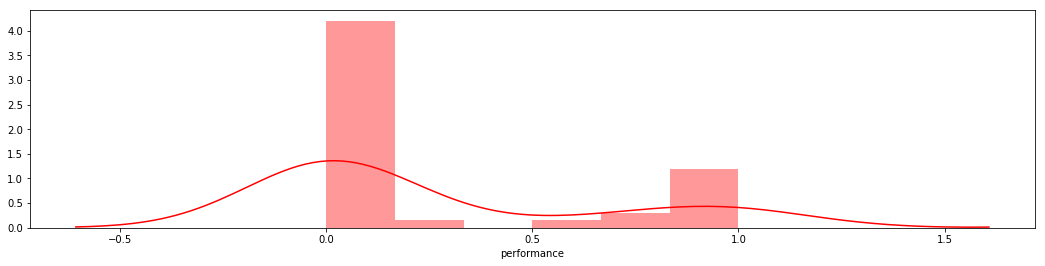

In [55]:
#Distribution
plt.figure(figsize=[18, 4])
sns.distplot(tasks_mean1['performance'], bins=6, color='red')

In [56]:
cutoff_task = 0.5 #More than 50% of consensus
print('All the hard tasks that go to Stage 2 are below {}'.format(cutoff_task))

All the hard tasks that go to Stage 2 are below 0.5


In [57]:
tasks_mean1[tasks_mean1['performance'] >= cutoff_task]

,prob_task,prob_worker,prob_answer,performance
task_id,,,,
task_2du,0.96,0.838571,0.966457,1.000000
task_Ljx,0.97,0.778571,0.976643,1.000000
task_3Pz,0.84,0.760000,0.878400,1.000000
task_opL,0.99,0.877143,0.991229,1.000000
task_cUd,0.98,0.885714,0.982286,1.000000
task_M4o,0.80,0.818571,0.836286,1.000000
task_ZyZ,0.92,0.821429,0.934286,0.857143
task_WQN,0.75,0.815714,0.796071,0.857143
task_TDf,0.57,0.832857,0.641871,0.714286


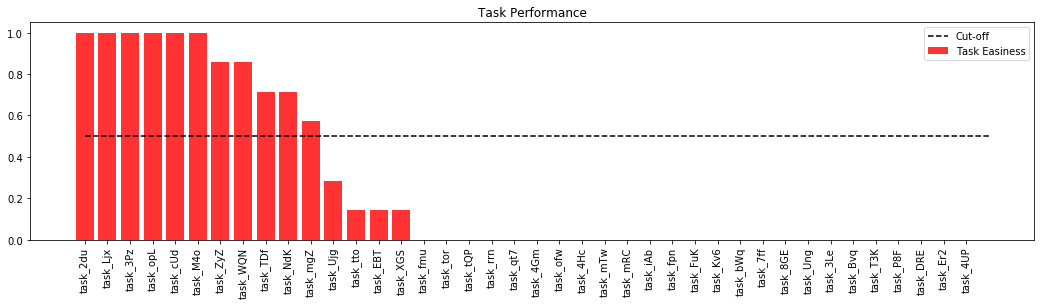

In [58]:
plt.figure(figsize=[18, 4])
axis = range(len(tasks_mean1))
plt.bar(axis, tasks_mean1['performance'], align='center', alpha=0.8, color='red', label='Task Easiness')
plt.hlines(y=cutoff_task, xmin=0, xmax=len(tasks_mean1), linestyles='--', label='Cut-off')
plt.xticks(axis, tasks_mean1.index, rotation=90)
plt.title('Task Performance')
plt.legend(loc='best')
plt.show()

- Trained Workers

In [59]:
workers_mean1 = df_tw1.groupby('worker_id').mean().sort_values('performance', ascending=False)
df_workers = pd.merge(workers_mean1.reset_index(), df_workers.drop('prob_worker',1), on='worker_id', how='left')

- prob_task: Average of difficulty of the tasks asigned to the workers, this measure should be close each other in order to make the metrics equivalent
- prob_worker: Prob to score correct
- prob_answer: Combined probability of score and task difficulty
- performance: Percentage of the times the worker score correct

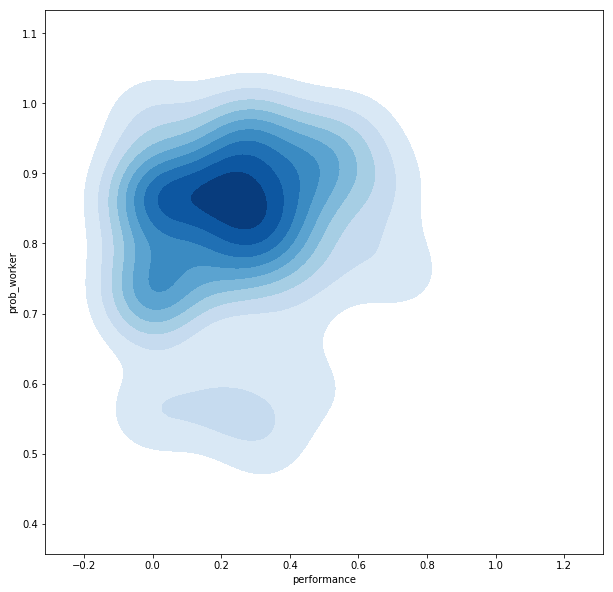

In [60]:
plt.figure(figsize=[10, 10])
sns.kdeplot(df_workers['performance'], df_workers['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)
#plt.hlines(y=df_workers['prob_worker'].quantile(.5), xmin=0, xmax=.4, linestyles='--', label='Cut-off')
#plt.vlines(x=cutoff_task, ymin=.4, ymax=1.1, linestyles='--', label='Cut-off')

In [61]:
databar = [go.Bar(x=df_workers.index, y=df_workers['performance'])]
py.iplot(databar, filename='basic_bar')

Maybe we don't want to let go the workers with high probability just because they had bad performance

In [62]:
df_workers.describe()

,prob_task,prob_worker,prob_answer,performance
count,65.000000,65.000000,65.000000,65.000000
mean,0.841112,0.818308,0.871060,0.258376
std,0.057029,0.120007,0.048602,0.227442
min,0.672000,0.500000,0.750720,0.000000
25%,0.800000,0.760000,0.839000,0.000000
50%,0.844000,0.850000,0.869567,0.250000
75%,0.875000,0.900000,0.908800,0.400000
max,0.960000,0.990000,0.966400,1.000000


In [63]:
cutoff1 = df_workers['performance'].quantile(.3)
cutoff2 = df_workers['prob_worker'].quantile(.5)
print('Cutoff: \n Performance: {} \n Probability: {}'.format(
    round(cutoff1, 3), round(cutoff2, 3)))

Cutoff: 
 Performance: 0.114 
 Probability: 0.85


In [64]:
df_workers #All workers

,worker_id,prob_task,prob_worker,prob_answer,performance,label_worker
0,Qubrf,0.895000,0.99,0.896050,1.000000,good_worker
1,59gyJ,0.810000,0.75,0.857500,0.750000,good_worker
2,oDKfU,0.800000,0.90,0.820000,0.666667,good_worker
3,CWKBK,0.930000,0.86,0.939800,0.666667,good_worker
4,Txsv4,0.941667,0.78,0.954500,0.666667,good_worker
5,kVpJe,0.860000,0.97,0.864200,0.600000,good_worker
6,LroGp,0.810000,0.94,0.821400,0.500000,good_worker
7,KCQVR,0.875000,0.92,0.885000,0.500000,good_worker
8,ErHht,0.935000,0.85,0.944750,0.500000,good_worker
9,qpeCb,0.795000,0.76,0.844200,0.500000,good_worker


---
### Stage 2 - Take the best workers
We are going take only the best workers, it means high probability and high performance, above certain percentile. 
As a logil decision is an OR

In [65]:
list_perf = [1 if i > cutoff1 else 0 for i in df_workers['performance']]
#list_perf

In [66]:
list_prob = [1 if i > cutoff2 else 0 for i in df_workers['prob_worker']]
#list_prob

In [72]:
flag_best_workers = []
for i in range(len(list_perf)):
    if list_perf[i] == 1 and list_prob[i] ==1 : #we need to be strict here
        flag_best_workers.append(1)
    else: flag_best_workers.append(0)

In [96]:
print('Selected Best Workers: {}'.format(sum(flag_best_workers)))

Selected Best Workers: 12


In [69]:
#if sum(trained_workers) % 2 == 0:
#    places = [idx for idx, i in enumerate(trained_workers) if i > 0] #Take out the last place where is a 1
#    trained_workers[places[-1]] = 0 # replace with a 0 to make an odd number of workers

In [70]:
df_workers['best_worker'] = flag_best_workers

In [71]:
df_workers2 = df_workers[df_workers['best_worker']==1]

But we want to "reset" them:

In [72]:
df_workers2 = df_workers2[['worker_id','prob_worker','label_worker']]
df_workers2

,worker_id,prob_worker,label_worker
0,8HmeJ,0.87,good_worker
1,ZNQoy,0.86,good_worker
3,33nTP,0.91,good_worker
6,PJqTr,0.95,good_worker
9,mmT2k,0.84,good_worker
10,jnrTJ,0.93,good_worker
13,hScA6,0.83,good_worker
16,pcmkB,0.82,good_worker
18,iYpPb,0.95,good_worker
19,njXh8,0.99,good_worker


In [73]:
best_workers = [i for i in df_workers2['worker_id']]

In [74]:
best_workers

['8HmeJ',
 'ZNQoy',
 '33nTP',
 'PJqTr',
 'mmT2k',
 'jnrTJ',
 'hScA6',
 'pcmkB',
 'iYpPb',
 'njXh8',
 'G4a8F',
 'tRBRr',
 'S5wZm',
 'LytKM']

- Now we take the tasks that we decide were already difficult
- Then we're going to add them in the df_tasks that we did not use
- This "rest" of the tasks remain are going to be performed for our final workers

In [75]:
tasks_mean1 = tasks_mean1.reset_index()

In [76]:
tasks_mean1

,task_id,prob_task,prob_worker,prob_answer,performance
0,task_5dx,0.88,0.885714,0.893714,1.000000
1,task_7tj,0.98,0.827143,0.983457,1.000000
2,task_Zv7,0.84,0.827143,0.867657,1.000000
3,task_ByK,0.90,0.811429,0.918857,1.000000
4,task_Js7,0.86,0.804286,0.887400,0.857143
5,task_NrQ,0.81,0.861429,0.836329,0.714286
6,task_YrK,0.76,0.787143,0.811086,0.714286
7,task_RYd,0.71,0.854286,0.752257,0.285714
8,task_QgV,0.94,0.772857,0.953629,0.142857
9,task_huE,0.55,0.852857,0.616214,0.142857


In [77]:
list_done_tasks = [1 if i > cutoff_task else 0 for i in tasks_mean1['performance']]
#trained_tasks

In [78]:
tasks_mean1['done_task'] = list_done_tasks

In [79]:
 #All those with value 1 is because was good consensus, so we don't need them to evaluate again
tasks_mean1[tasks_mean1['done_task']==1]

,task_id,prob_task,prob_worker,prob_answer,performance,done_task
0,task_5dx,0.88,0.885714,0.893714,1.000000,1
1,task_7tj,0.98,0.827143,0.983457,1.000000,1
2,task_Zv7,0.84,0.827143,0.867657,1.000000,1
3,task_ByK,0.90,0.811429,0.918857,1.000000,1
4,task_Js7,0.86,0.804286,0.887400,0.857143,1
5,task_NrQ,0.81,0.861429,0.836329,0.714286,1
6,task_YrK,0.76,0.787143,0.811086,0.714286,1


In [80]:
done_tasks = tasks_mean1[tasks_mean1['done_task']==1]['task_id']

- Those trained_task with value 1 don't select them
- The best workers will do the rest of the job
- Then we measure the accuracy of the over tasks and workers
- Simulations and ploting the acuracy and the best workers, 
- Ploting workers converge on truth answer

In [81]:
done_tasks = [i for i in done_tasks]

In [82]:
done_tasks

['task_5dx',
 'task_7tj',
 'task_Zv7',
 'task_ByK',
 'task_Js7',
 'task_NrQ',
 'task_YrK']

In [83]:
len(done_tasks)

7

We take the tasks that go to stage 2

In [84]:
len(df_tasks)

100

In [85]:
# Take all the rest of the tasks excluding those that already we have concensus
# This is the number we want to evaluate in stage 2
df_tasks2 = df_tasks[~df_tasks['task_id'].isin(done_tasks)]
len(df_tasks2)

93

---
### Task Assignation

- **Tasks Re-do**

Before we assigne the best workers to the rest of the tasks we have to be sure that the workers dont responde the same task

In [86]:
# All the tasks done for the best workers and is not in the list of tasks already done
tasks_redo = df_tw1[~df_tw1['task_id'].isin(done_tasks)]

In [87]:
tasks_redo = tasks_redo.reset_index()

In [88]:
tasks_redo.head(10)

,index,task_id,worker_id,real_answers,label_task,prob_task,label_worker,prob_worker,prob_answer,worker_answers,performance
0,0,task_wdC,vhafG,liver,easy_task,0.77,good_worker,0.82,0.8114,lung,0
1,1,task_wdC,raLqr,liver,easy_task,0.77,poor_worker,0.61,0.8597,lung,0
2,2,task_wdC,d4uk2,liver,easy_task,0.77,poor_worker,0.63,0.8551,lung,0
3,3,task_wdC,ohh86,liver,easy_task,0.77,poor_worker,0.73,0.8321,lung,0
4,4,task_wdC,S5wZm,liver,easy_task,0.77,good_worker,0.99,0.7723,liver,1
5,5,task_wdC,tRBRr,liver,easy_task,0.77,good_worker,0.83,0.8091,lung,0
6,6,task_wdC,iYpPb,liver,easy_task,0.77,good_worker,0.95,0.7815,blood,0
7,7,task_szS,V66mp,liver,easy_task,0.98,good_worker,0.77,0.9846,lung,0
8,8,task_szS,PKegy,liver,easy_task,0.98,good_worker,0.82,0.9836,lung,0
9,9,task_szS,pcmkB,liver,easy_task,0.98,good_worker,0.82,0.9836,lung,0


In [89]:
tasks_redo_unique = tasks_redo['task_id'].unique()
tasks_redo_unique =  [i for i in tasks_redo_unique]
len(tasks_redo_unique) 

33

** Check Groups: ** All the trained and consensus tasks + All the tasks already done = Trained Tasks

In [90]:
print(' Done Taks: {} \n Tasks to redo: {} \n Original Tasks to train: {}  \n Value: {}'.format(
    len(done_tasks), len(tasks_redo_unique), tasks_to_train, len(done_tasks)+len(tasks_redo_unique)==tasks_to_train))

 Done Taks: 7 
 Tasks to redo: 33 
 Original Tasks to train: 40  
 Value: True


    for each task
        select odd number of workers 
        check if the workers already done this task and exclude them
            calculate how many spaces left
            re-select a this number of workers
            while the number of workers is the same as my odd number I want from the begining


In [150]:
tasks_workers2 = [] #we should take in account that there is a low chance that the worker repat the task
for i in tasks_redo_unique:
    each = [i for i in tasks_redo[tasks_redo['task_id']==str(i)]['worker_id']] # show the worker id of every task
    rest_workers = [worker for worker in set(best_workers)-set(each)] # select all those not did the task before
    if len(rest_workers) > workers_per_task:
        tasks_workers2.append(np.random.choice(rest_workers, workers_per_task, replace=False))
    else:
        tasks_workers2.append(np.random.choice(rest_workers, workers_per_task))
        
tasks_workers2 = [worker for sublist in tasks_workers2 for worker in sublist] #flat and clean list

In [151]:
list_tasks2 = [[tasks_redo_unique[i]]*workers_per_task for i in range(len(tasks_redo_unique))] #replicate the tasks to train 
list_tasks2 = [item for sublist in list_tasks2 for item in sublist] #flat and clean list

In [152]:
df_tw2 = pd.DataFrame()
df_tw2['task_id'] = list_tasks2
df_tw2['worker_id'] = tasks_workers2

In [153]:
df_tw2['task_id'].unique() #Tasks to redo because no consensus

array(['task_wdC', 'task_szS', 'task_U4z', 'task_Ffk', 'task_eNp',
       'task_nvt', 'task_fme', 'task_26Y', 'task_RYd', 'task_Zbu',
       'task_Mgf', 'task_ptK', 'task_ZmL', 'task_fun', 'task_QgV',
       'task_dL6', 'task_ziz', 'task_wTV', 'task_zGC', 'task_os9',
       'task_cVM', 'task_7ev', 'task_akf', 'task_H6M', 'task_UcF',
       'task_UPX', 'task_jdo', 'task_2EL', 'task_cfo', 'task_NQW',
       'task_huE', 'task_NDm', 'task_AVq'], dtype=object)

- **Tasks Un-done**

In [95]:
tasks_undone_unique = df_tasks[~df_tasks['task_id'].isin(training_tasks)]['task_id']
tasks_undone_unique = [i for i in tasks_undone_unique]
len(tasks_undone_unique)

60

** Check Groups: ** Tasks re-do unique + Tasks un-done unique = df_tasks2 

In [96]:
print(' Tasks Re-do: {} \n Tasks Not Done: {}'.format(
    len(tasks_redo_unique) , len(tasks_undone_unique)))

 Tasks Re-do: 30 
 Tasks Not Done: 60


In [97]:
tasks_workers3 = []
for i in tasks_undone_unique:
    tasks_workers3.append(np.random.choice(best_workers, workers_per_task, replace=False))

tasks_workers3 = [worker for sublist in tasks_workers3 for worker in sublist] #flat and clean list

In [98]:
list_tasks3 = [[tasks_undone_unique[i]]*workers_per_task for i in range(len(tasks_undone_unique))] #replicate the tasks to train 
list_tasks3 = [item for sublist in list_tasks3 for item in sublist] #flat and clean list

In [99]:
df_tw3 = pd.DataFrame()
df_tw3['task_id'] = list_tasks3
df_tw3['worker_id'] = tasks_workers3

In [100]:
df_tw3['task_id'].unique() #Tasks not done before

array(['task_ZgZ', 'task_wB2', 'task_okw', 'task_zxR', 'task_6wx',
       'task_SXu', 'task_EHw', 'task_sHw', 'task_eaB', 'task_cBV',
       'task_kcT', 'task_yZ3', 'task_5NB', 'task_t7W', 'task_hhr',
       'task_QK6', 'task_B89', 'task_MiU', 'task_ZuR', 'task_z6h',
       'task_cMK', 'task_EKs', 'task_8Q6', 'task_6b6', 'task_2n4',
       'task_PHP', 'task_Pp8', 'task_SSc', 'task_Vzd', 'task_dVn',
       'task_efB', 'task_KGN', 'task_Agv', 'task_UoL', 'task_KUD',
       'task_YJo', 'task_5Ao', 'task_dX2', 'task_zhc', 'task_TYR',
       'task_QPJ', 'task_jEF', 'task_4yY', 'task_3Ey', 'task_5Pi',
       'task_x4z', 'task_ybA', 'task_oTg', 'task_iGt', 'task_b3d',
       'task_Dqx', 'task_X3T', 'task_iw9', 'task_vwf', 'task_HXK',
       'task_qaJ', 'task_anm', 'task_GEM', 'task_kTG', 'task_SVB'], dtype=object)

---
### Stage 2 - Final Join

In [101]:
df_tw = df_tw2.append(df_tw3, ignore_index=True)

In [102]:
len(df_tw['task_id'].unique())

90

In [105]:
df_tw = pd.merge(df_tw, df_tasks2, on='task_id', how='left')
df_tw = pd.merge(df_tw, df_workers2, on='worker_id', how='left')

In [106]:
#Probability to asnwer correct
df_tw['prob_answer'] = 1-(df_tw['prob_worker']*(1-df_tw['prob_task']))

In [107]:
df_tw['prob_answer'].head(10)

0    0.9032
1    0.9076
2    0.8977
3    0.8944
4    0.8933
5    0.8977
6    0.8966
7    0.7648
8    0.7284
9    0.7312
Name: prob_answer, dtype: float64

In [108]:
# We want to get where is the position of the real_answer column on the answer_key array
positions = []
for answer in df_tw['real_answers']:
    for k in range(len(answers_key)):
        if answers_key[k] == answer:
            positions.append(k)

In [109]:
# Assign a vector of probabilities depending on the position of the item on anser_key array
list_vect_probs = []
for p in df_tw['prob_answer']:
    for i in positions:
        vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
        vec_probs.insert(i,p) #insert place, value
    list_vect_probs.append(vec_probs)

In [110]:
#"Predict" every answer
worker_answers = []
for vec in list_vect_probs:
    worker_answers.append(np.random.choice(answers_key, 1, p=vec))

worker_answers = [item for answer in worker_answers for item in answer]

In [111]:
df_tw['worker_answers'] = worker_answers

In [112]:
#We match the real answers with worker answers
vec_matches = df_tw['worker_answers'] == df_tw['real_answers']
predict_value =[1 if i == True else 0 for i in vec_matches]

In [113]:
df_tw['performance'] = predict_value

In [114]:
df_tw

,task_id,worker_id,real_answers,label_task,prob_task,prob_worker,label_worker,prob_answer,worker_answers,performance
0,task_CCR,qN3VD,lung,easy_task,0.89,0.88,good_worker,0.9032,lung,1
1,task_CCR,EJJq8,lung,easy_task,0.89,0.84,good_worker,0.9076,lung,1
2,task_CCR,aTJyP,lung,easy_task,0.89,0.93,good_worker,0.8977,lung,1
3,task_CCR,Xvqfs,lung,easy_task,0.89,0.96,good_worker,0.8944,blood,0
4,task_CCR,uki7z,lung,easy_task,0.89,0.97,good_worker,0.8933,lung,1
5,task_CCR,fkVEk,lung,easy_task,0.89,0.93,good_worker,0.8977,lung,1
6,task_CCR,wG48Z,lung,easy_task,0.89,0.94,good_worker,0.8966,lung,1
7,task_Xyb,zW85k,lung,hard_task,0.72,0.84,good_worker,0.7648,lung,1
8,task_Xyb,uki7z,lung,hard_task,0.72,0.97,good_worker,0.7284,lung,1
9,task_Xyb,Xvqfs,lung,hard_task,0.72,0.96,good_worker,0.7312,lung,1


In [117]:
y1 = [i for i in df_tw[df_tw['label_task'] == 'easy_task']['prob_answer']]
y2 = [i for i in df_tw[df_tw['label_task'] == 'hard_task']['prob_answer']]
axis = df_tw.index

# Create traces
trace1 = go.Scatter(x = axis, y = y1, mode = 'markers', name = 'easy_task')
trace2 = go.Scatter(x = axis, y = y2, mode = 'markers', name = 'hard_task')

data = [trace1, trace2]
py.iplot(data, filename='Probabilities')

---
### Measuring Performance

Let's aggregate the tasks by the mean. the average of the predict value is the same as calculate the number of times a worker answer right over the number of workers per task.  

The range of the predict value goes from 0 to 1, so it means that the more closest to 1 the workers get more consensus, in the other hand if is closest to 0 then means that everyone said different things 

- Trained Tasks

In [118]:
tasks_mean = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)
tasks_mean['performance']#.head(10)

task_id
task_PA7    1.000000
task_UKh    1.000000
task_x2C    1.000000
task_SVB    1.000000
task_cBV    1.000000
task_bzA    1.000000
task_MyY    1.000000
task_EHw    0.857143
task_CCR    0.857143
task_Pp8    0.857143
task_SXu    0.857143
task_X3T    0.857143
task_anm    0.857143
task_yZ3    0.857143
task_dVn    0.714286
task_QK6    0.714286
task_wB2    0.714286
task_Xyb    0.571429
task_VfC    0.428571
task_Dqx    0.428571
task_hhr    0.285714
task_zxR    0.285714
task_HXK    0.142857
task_SSc    0.142857
task_efB    0.142857
task_g37    0.142857
task_hkT    0.142857
task_jEF    0.142857
task_jco    0.142857
task_kcT    0.142857
              ...   
task_KUD    0.000000
task_Lnf    0.000000
task_MiU    0.000000
task_GEM    0.000000
task_EKs    0.000000
task_PHP    0.000000
task_PeU    0.000000
task_BjJ    0.000000
task_B89    0.000000
task_QPJ    0.000000
task_B7L    0.000000
task_Agv    0.000000
task_TYR    0.000000
task_8Q6    0.000000
task_UoL    0.000000
task_7YT    0.000000
task_

---
### Global Performance

We're going to define a global performance in order to know the reate of the tasks where we had consensus:
    - All the tasks abobve .5 on the mean of the performance means that it was consensus in this task

In [131]:
accu = (len(tasks_mean[tasks_mean['performance'] >= .5]) + len(done_tasks)) / len(df_tasks)

In [132]:
accu

0.28

In [159]:
data = [dict(
        visible = False,
        line=dict(color='00CED1', width=6),
        name = '𝜈 = '+str(step),
        x = np.arange(0,10,0.01),
        y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
data[10]['visible'] = True

steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "Frequency: "},
    pad = {"t": 50},
    steps = steps
)]

layout = dict(sliders=sliders)
fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Wave Slider')